In [1]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

function least_squares_solution(mat, y)
    inv(transpose(mat) * mat)*transpose(mat) * y
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [2]:
max_order = 10
discretization = 50
zernike_samples = []
ordering = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 == 0
            Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
            push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
            push!(ordering, (n, m))
            if m !=0
                Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                push!(ordering, (n, -m))
            end
        end
    end
end
Z = reduce(hcat, zernike_samples);

In [3]:
σ1 = .1
σ2 = 1
amp = 1 # Used to make the small angle approximation work better.
function gaussian(σ1, σ2)
    function func(ρ, ϕ)
        x = ρ*cos(ϕ)
        y = ρ*sin(ϕ)
        amp * exp(-x^2/σ1^2 + -y^2/σ2^2)
    end
end
xx, yy, zz = sample_across_unit_disk(gaussian(σ1, σ2), discretization)
G = zz[:];

In [4]:
coefficients = least_squares_solution(Z, G)

66-element Array{BigFloat,1}:
  0.08210542600553885442483078487376550335428597308190366431398744490920151297902201
 -1.082907032661394540135664472607706275604776678773308709930790906720766532710202e-18
  2.843444923684993983609805002037940548640470693415365846565583642433114024455454e-78
 -0.1283562448626368615325285043752977031562713014117872744861610148643279345741557
 -0.1348459107499467544170513371147732348575061771012895898313804551136590685107705
  2.315165501439140686222175129540626830521304800456083962755358739342108875149687e-80
 -8.516127262141278884635098332771139272733919153886237405476419668730679483915266e-18
 -5.354794139973940187960091876813920389133378056471463754510670753070594772269907e-78
 -7.495046663622758904993844015082392784168053750695038135406058285363219047545736e-18
  2.943661692882829145011268634112826166832513513806506471463510377190548321121486e-78
  0.1032319246526276973238067943965000901262781179713168843601412853373273484641398
  0.16198239510472212343

In [5]:
reconstruction = zeros(discretization*discretization)
for (i, zernike_sample) in enumerate(zernike_samples)
    reconstruction += coefficients[i] * zernike_sample
end

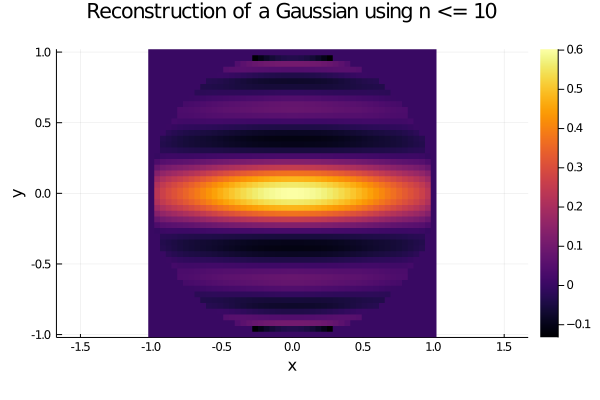

In [6]:
using Plots
plot(heatmap(xx, yy, reshape(reconstruction, (discretization, discretization))), aspectratio = true, xlabel="x", ylabel="y", title="Reconstruction of a Gaussian using n <= 10")

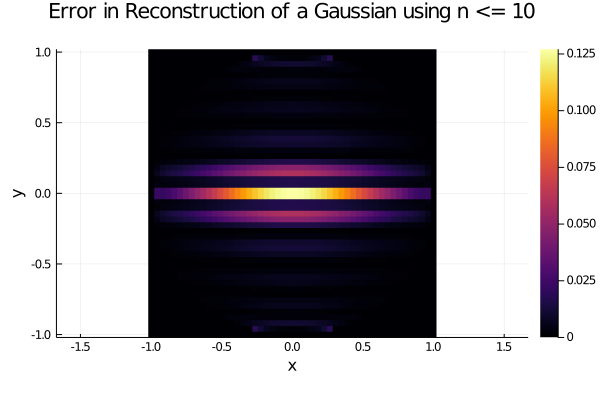

In [7]:
using Plots
diff = sample_across_unit_disk(gaussian(σ1,σ2), discretization)[3] - reshape(reconstruction, (discretization, discretization))
diff = diff.*diff
plot(heatmap(xx, yy, diff), aspectratio = true, xlabel="x", ylabel="y", title="Error in Reconstruction of a Gaussian using n <= 10")

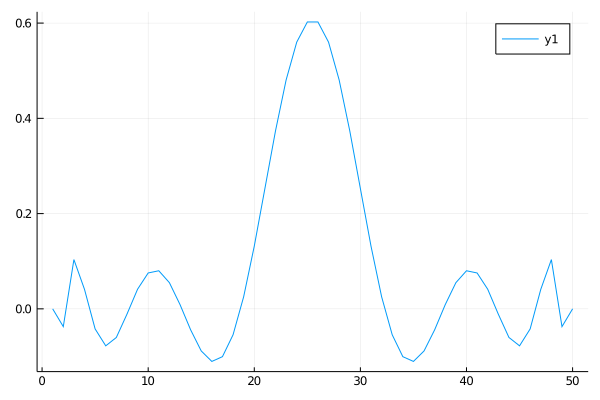

In [8]:
plot(reshape(reconstruction, (discretization, discretization))[:,Int64(discretization/2)])

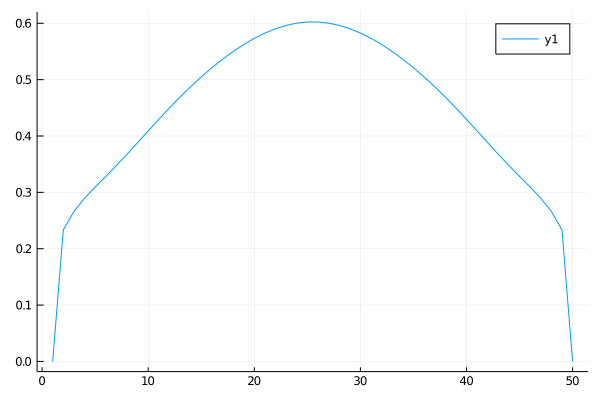

In [9]:
plot(reshape(reconstruction, (discretization, discretization))[Int64(discretization/2), :])

In [10]:
lookup = Dict(zip(ordering, coefficients));
zernike_even_coefficients = []
zernike_odd_coefficients = []
curr_even = []
curr_odd = []
for n in range(0, max_order, step=1)
    for m in range(0, n, step=1)
        if (n-m)%2 != 0
            push!(curr_even, 0)
            push!(curr_odd, 0)
        else
            if m == 0
                push!(curr_even, lookup[(n, m)])
                push!(curr_odd, lookup[(n, -m)])
            else
                push!(curr_even, lookup[(n, m)])
                push!(curr_odd, lookup[(n, -m)])
            end
        end
    end
    push!(zernike_even_coefficients, curr_even)
    push!(zernike_odd_coefficients, curr_odd)
    curr_even = []
    curr_odd = []
end

In [11]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, max(length(zernikeeven), length(zernikeodd)) - 1, step=1)
    function evaluator(ρ, ϕ)
        ψ = ψ0
        for order in orders
            μ = order * ω
            H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
            _, ψ = timeevolution.master_dynamic(T, ψ, H; rates=[Γ])
            ψ = last(ψ)
        end
        ψ
    end
end

function gaussian_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = gaussian(σ1, σ2)(ρ, ϕ) * sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    evolution_time = π/2
    step_size = evolution_time/1
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    last(ψ)
end

gaussian_spin_profile (generic function with 1 method)

In [12]:
Γ = 1/62
ω = 2*π*180E3
θ = -π/2;

In [13]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time =  50E-6
U = π/(evolution_time)
step_size = evolution_time
T = [0.0:step_size:evolution_time;];
sequential_exact_evolution = sequential_exact_evolution_evaluator_factory(ψ0, T, zernike_even_coefficients, zernike_odd_coefficients, U, θ, ω, b)

(::var"#evaluator#14"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Any,1},Array{Any,1},Float64,Float64,Float64,SpinBasis{1//2,Int64},StepRange{Int64,Int64}}) (generic function with 1 method)

In [14]:
using Plots
max_ρ = 1
min_ρ = .0
ρs = range(min_ρ, max_ρ, step=max_ρ/20)
angle = 0
target2 = [Real.(expect(sigmax(b), gaussian_spin_profile(ρ, angle))) for ρ in ρs]
y2s = [Real.(expect(sigmax(b), sequential_exact_evolution(ρ, angle))) for ρ in ρs];

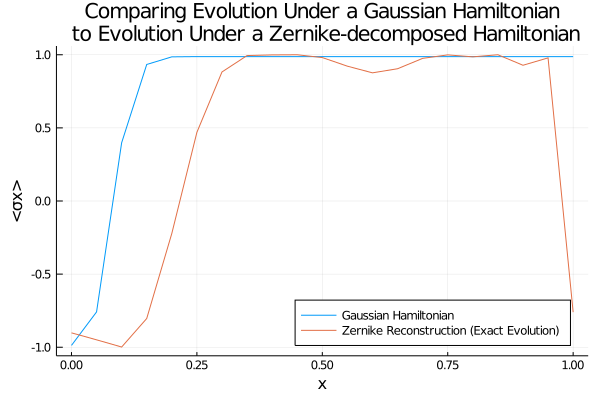

In [15]:
plot(ρs, [target2, y2s], labels=["Gaussian Hamiltonian" "Zernike Reconstruction (Exact Evolution)"], legend=:bottomright, ylabel="<σx>", xlabel="x", title="Comparing Evolution Under a Gaussian Hamiltonian\n to Evolution Under a Zernike-decomposed Hamiltonian")

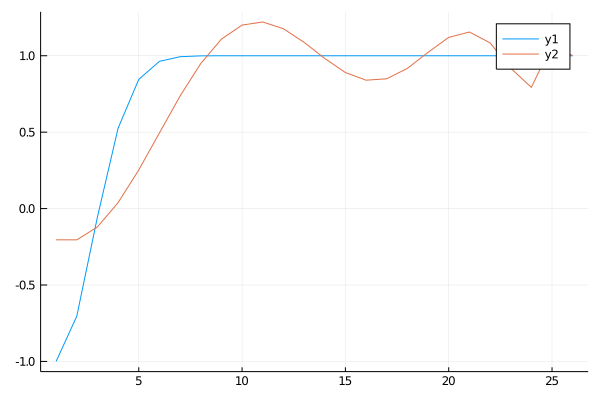

In [16]:
rec = reshape(-2 * reconstruction .+ 1, (discretization, discretization))[Int64(discretization/2):discretization,Int64(discretization/2)]
exact = [-2 * gaussian(σ1, σ2)(2/discretization * i , 0) + 1 for i in range(0., discretization/2, step=1)]
plot([exact, rec])

In [17]:
using Plots
max_ρ = 1
min_ρ = .0
ρs = range(min_ρ, max_ρ, step=max_ρ/20)
angle = π/2
target = [Real.(expect(sigmax(b), gaussian_spin_profile(ρ, angle))) for ρ in ρs]
ys = [Real.(expect(sigmax(b), sequential_exact_evolution(ρ, angle))) for ρ in ρs];

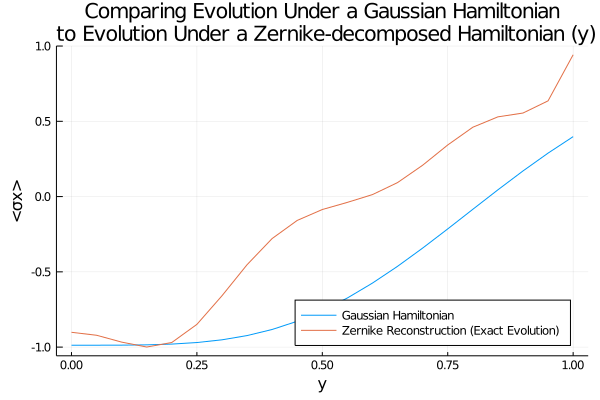

In [18]:
plot(ρs, [target, ys], labels=["Gaussian Hamiltonian" "Zernike Reconstruction (Exact Evolution)"], legend=:bottomright, ylabel="<σx>", xlabel="y", title="Comparing Evolution Under a Gaussian Hamiltonian\n to Evolution Under a Zernike-decomposed Hamiltonian (y)")

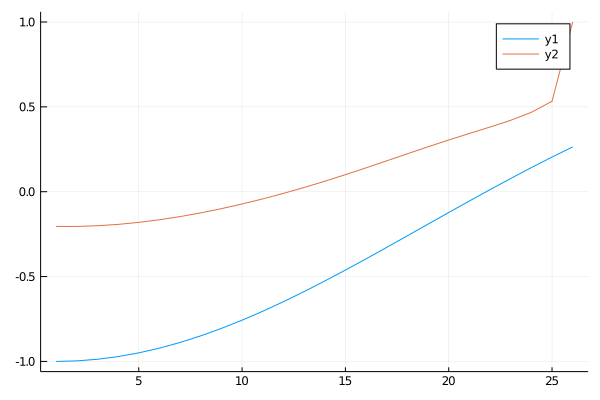

In [19]:
rec = reshape(-2 * reconstruction .+ 1, (discretization, discretization))[Int64(discretization/2), Int64(discretization/2):discretization]
exact = [-2 * gaussian(σ1, σ2)(2/discretization * i , π/2) + 1 for i in range(0., discretization/2, step=1)]
plot([exact, rec])

#  Plot \sigma as a function of Zernike polynomials that we need to converge.

In [20]:
discretization = 50
function Zmat(max_order)
    zernike_samples = []
    ordering = []
    for n in range(0, max_order, step=1)
        for m in range(0, n, step=1)
            if (n-m)%2 == 0
                Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
                push!(ordering, (n, m))
                if m !=0
                    Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                    push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                    push!(ordering, (n, -m))
                end
            end
        end
    end
    Z = reduce(hcat, zernike_samples);
end

function Zsamples(max_order)
    zernike_samples = []
    ordering = []
    for n in range(0, max_order, step=1)
        for m in range(0, n, step=1)
            if (n-m)%2 == 0
                Zeven(ρ, ϕ) = R(n, m, ρ) * cos(m * ϕ)
                push!(zernike_samples, sample_across_unit_disk(Zeven, discretization)[3][:])
                push!(ordering, (n, m))
                if m !=0
                    Zodd(ρ, ϕ) = R(n, m, ρ) * sin(m * ϕ)
                    push!(zernike_samples, sample_across_unit_disk(Zodd, discretization)[3][:])
                    push!(ordering, (n, -m))
                end
            end
        end
    end
    zernike_samples
end

function gaussian(σ1, σ2)
    function func(ρ, ϕ)
        x = ρ*cos(ϕ)
        y = ρ*sin(ϕ)
        exp(-x^2/σ1^2 + -y^2/σ2^2)
    end
end

gaussian (generic function with 1 method)

In [54]:
for (i, el) in enumerate(zz)
    for (j, ell) in enumerate(el)
        print(length(el), "\n")
        print(el, "\n")
    end
end

1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.37142041716361135
1
0.3789204509351905
1
0.3852860387313125
1
0.3904554179834493
1
0.3943779176127564
1
0.39701478483079394
1
0.3983398225176296
1
0.3983398225176296
1
0.3970147848307939
1
0.3943779176127564
1
0.3904554179834493
1
0.3852860387313125
1
0.3789204509351905
1
0.37142041716361135
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.3701849241935852
1
0.38145396731806297
1
0.391758563769513
1
0.40100317959906473
1
0.40910057

1
0.6902655614291886
1
0.667645233546609
1
0.6436181076732715
1
0.618391782850982
1
0.5921777979276908
1
0.5651887204155432
1
0.5376353372097581
1
0.5097239976248022
1
0.48165415352963065
1
0.4536161347862825
1
0.4257891909499133
1
0.39833982251762956
1
0.3714204171636114
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.38528603873131256
1
0.41321038153684936
1
0.44168447165207386
1
0.47055023256685585
1
0.4996349480975594
1
0.5287526770630897
1
0.5577059843327733
1
0.5862879722322873
1
0.6142845881509192
1
0.6414771762363722
1
0.6676452335466089
1
0.6925693242051978
1
0.7160340992200929
1
0.7378313648982816
1
0.7577631394134485
1
0.7756446352160367
1
0.7913071047250886
1
0.8046004881684758
1
0.8153958055474629
1
0.8235872394415472
1
0.8290938616328278
1
0.8318609641553594
1
0.8318609641553594
1
0.8290938616328278
1
0.8235872394415472
1
0.8153958055474629
1
0.8046004881684758
1
0.7913071047250886
1
0.7756446352160367
1
0.7577631394134485
1
0.7378313648982816
1
0.7160340992200929
1
0.69256932420

1
0.49466555754302555
1
0.4612365557073309
1
0.4286360784384592
1
0.3970147848307939
1
0.0
1
0.0
1
0.3983398225176296
1
0.4300666522598106
1
0.4627759336907452
1
0.4963165048910026
1
0.5305173902447976
1
0.5651887204155434
1
0.6001230420176751
1
0.6350970168166279
1
0.6698735009303096
1
0.7042039847975423
1
0.7378313648982816
1
0.7704930086530117
1
0.8019240649001935
1
0.8318609641553594
1
0.8600450457849926
1
0.8862262435500214
1
0.910166756919628
1
0.9316446333126542
1
0.9504571861236039
1
0.9664241751045172
1
0.9793906794086937
1
0.9892295992955481
1
0.995843730018902
1
0.9991673605810142
1
0.9991673605810142
1
0.995843730018902
1
0.9892295992955481
1
0.9793906794086937
1
0.9664241751045172
1
0.9504571861236039
1
0.9316446333126542
1
0.910166756919628
1
0.8862262435500214
1
0.8600450457849926
1
0.8318609641553594
1
0.8019240649001935
1
0.7704930086530117
1
0.7378313648982816
1
0.7042039847975423
1
0.6698735009303096
1
0.6350970168166279
1
0.6001230420176751
1
0.5651887204155434
1
0.

1
0.3983398225176296
1
0.42721026327823064
1
0.45664907720514625
1
0.48649283203595456
1
0.516562959831464
1
0.5466672195820604
1
0.5766014869048043
1
0.6061518542749371
1
0.6350970168166281
1
0.6632109104511392
1
0.6902655614291886
1
0.7160340992200929
1
0.7402938786443031
1
0.7628296522482734
1
0.783436730430958
1
0.8019240649001935
1
0.8181171907787423
1
0.8318609641553594
1
0.8430220350909353
1
0.8514910009903458
1
0.8571841917261671
1
0.8600450457849926
1
0.8600450457849926
1
0.8571841917261671
1
0.8514910009903458
1
0.8430220350909353
1
0.8318609641553594
1
0.8181171907787423
1
0.8019240649001935
1
0.783436730430958
1
0.7628296522482734
1
0.7402938786443031
1
0.7160340992200929
1
0.6902655614291886
1
0.6632109104511393
1
0.635097016816628
1
0.6061518542749371
1
0.5766014869048042
1
0.5466672195820604
1
0.516562959831464
1
0.48649283203595456
1
0.45664907720514625
1
0.4272102632782306
1
0.39833982251762967
1
0.3701849241935852
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.38528603873131256
1


1
0.4132103815368493
1
0.39833982251762956
1
0.3827270707434298
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.3714204171636114
1
0.38528603873131256
1
0.39833982251762967
1
0.4104659474480996
1
0.4215542734530774
1
0.43150200062432653
1
0.440215252313344
1
0.4476105481620547
1
0.45361613478628254
1
0.4581731444693249
1
0.4612365557073309
1
0.4627759336907452
1
0.4627759336907452
1
0.4612365557073309
1
0.4581731444693249
1
0.45361613478628254
1
0.4476105481620547
1
0.440215252313344
1
0.4315020006243266
1
0.4215542734530774
1
0.4104659474480996
1
0.39833982251762967
1
0.3852860387313126
1
0.37142041716361135
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.0
1
0.3701849241935852
1
0.38145396731806297
1
0.391758563769513
1
0.40100317959906473
1
0.40910057341621403
1


In [59]:
using Plots
all_ns = []
all_rs = []
σs = range(.1, 1, step=.3)
r2_vals = [.01]
tolerance = .01
for r2_val in r2_vals
    r2s = []
    ns = []
    for σ1 in σs
        for σ2 in σs
            count = 0
            r2 = 1
            max_n = 1
            while r2 > r2_val
                Z = Zmat(max_n)
                xx, yy, zz = sample_across_unit_disk(gaussian(σ1, σ2), discretization)
                for el in zz
                    if !isapprox(el, 0, atol=tolerance)
                        count += 1
                    end
                end
                G = zz[:];
                coefficients = least_squares_solution(Z, G)
                reconstruction = zeros(discretization*discretization)
                zernike_samples = Zsamples(max_n)
                for (i, zernike_sample) in enumerate(zernike_samples)
                    reconstruction += coefficients[i] * zernike_sample
                end
                max_n += 1
                print(max_n)
                r2 = sum((reconstruction - G).*(reconstruction - G))/count
            end
            push!(ns, max_n)
            push!(r2s, r2)
        end
    end
    push!(all_ns, ns)
    push!(all_rs, r2s)
end


23456789234567234567823456789234567234232342345678232323234567892342323

In [60]:
reshape(all_ns[1], (length(σs), length(σs)))

4×4 Array{Any,2}:
 9  7  8  9
 7  4  3  4
 8  3  3  3
 9  4  3  3

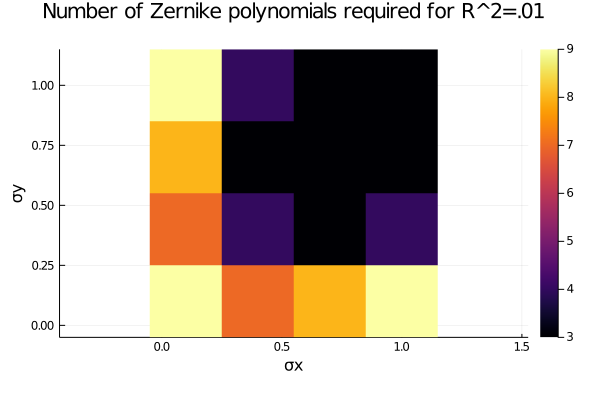

In [62]:
using Plots
plot(heatmap(σs, σs, reshape(all_ns[1], (length(σs), length(σs)))), aspectratio = true, xlabel="σx", ylabel="σy", title="Number of Zernike polynomials required for R^2=.01")

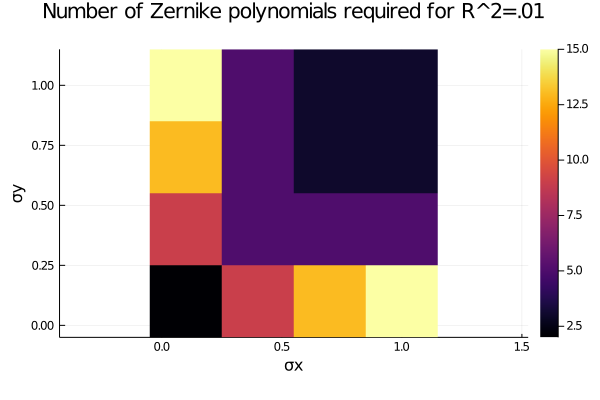

In [25]:
using Plots
plot(heatmap(σs, σs, reshape(all_ns[1], (length(σs), length(σs)))), aspectratio = true, xlabel="σx", ylabel="σy", title="Number of Zernike polynomials required for R^2=.01")

In [26]:
gaussian(0., 0.)(2.,1.)

0.0

In [27]:
exp(-1/0)

0.0